In [1]:
# !pip install git+https://github.com/google-deepmind/graphcast.git

!pip install chex
!pip install dm-haiku
!pip install dm-tree
!pip install jraph
!pip install rtree
!pip install trimesh
!pip install typing_extensions
!pip install xarray

# !pip freeze

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.2/535.2 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.6/694.6 kB 11.7 MB/s eta 0:00:00


jraph deep dive

when defining a graph object using jraph

In [2]:
import jax.numpy as jnp
import jraph

nodes = jnp.array([[[0.0, 0.0], [0.0, 0.0]],
                   [[0.1, 0.1], [0.1, 0.1]],
                   [[0.2, 0.2], [0.2, 0.2]],
                   [[0.3, 0.3], [0.3, 0.3]]])
senders = jnp.array([0, 0, 1, 2])
receivers = jnp.array([1, 2, 3, 3])
edges = jnp.array([[5.], [6.], [7.], [8.]])
n_node = jnp.array([4])
n_edge = jnp.array([4])
global_context = jnp.array([[1]])
graph = jraph.GraphsTuple(
    nodes=nodes,
    edges=edges,
    senders=senders,
    receivers=receivers,
    n_node=n_node,
    n_edge=n_edge,
    globals=global_context
    )

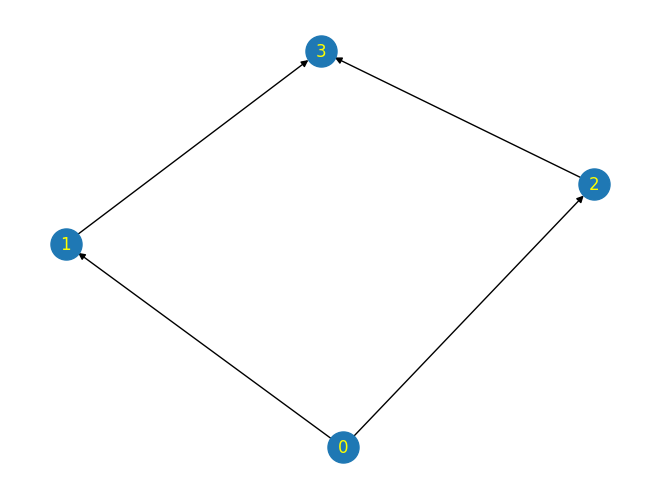

In [3]:
import networkx as nx

def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  nx.draw(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')

draw_jraph_graph_structure(graph)

In [ ]:
class TypedGraph(NamedTuple):
  """A graph with typed nodes and edges.

  A typed graph is made of a context, multiple sets of nodes and multiple
  sets of edges connecting those nodes (as indicated by the EdgeSetKey).
  """

  context: Context
  nodes: Mapping[str, NodeSet]
  edges: Mapping[EdgeSetKey, EdgeSet]

and the global outputs correspond to a single vector or tensor.

Context has the following attributes

In [ ]:
class Context(NamedTuple):
  n_graph: ArrayLike
  features: ArrayLikeTree

the edge and node outputs typically correspond to lists of vectors or tensors, one per edge or node

Nodes have the following attributes:

In [ ]:
class NodeSet(NamedTuple):
  n_node: ArrayLike
  features: ArrayLikeTree

Edges have the following attributes:

In [ ]:
class EdgeSet(NamedTuple):
  n_edge: ArrayLike
  indices: EdgesIndices
  features: ArrayLikeTree

in function GraphNetwork, a graph is constructed in following manner. When a graph, G, is provided as input to a GN block, the computations proceed from the edge, to the node, to the global level. (Algorithm 1 figure in the paper) <br>
Note this implementation doesn't use MLP because the graph network block isn't necessarily based on neural network, it could be functions as well. <br>
Additionally, graphs represent entities and their relations as sets, which are invariant to permutations.



function takes in the following arguments: (A GN block contains three “update” functions, and three “aggregation” functions)

    update_edge_fn: mapping of functions used to update a subset of the edge types, indexed by edge type name.

    update_node_fn: mapping of functions used to update a subset of the node types, indexed by node type name.

    update_global_fn: function used to update the globals or None to deactivate globals updates.

    aggregate_edges_for_nodes_fn: function used to aggregate messages to each node.

    aggregate_nodes_for_globals_fn: function used to aggregate the nodes for the globals.

    aggregate_edges_for_globals_fn: function used to aggregate the edges for the globals.

update_edge_fn is mapped across all edges to compute per-edge updates, update_node_fn is mapped across all nodes to compute per-node updates, and update_global_fn is applied once as the global update. The aggregate functions each take a set as input, and reduce it to a single element which represents the aggregated information. Crucially, the aggregate functions must be invariant to permutations of their inputs, and should
take variable numbers of arguments (e.g., elementwise summation, mean, maximum, etc.) (Battaglia et al., 2018)

Graph object is defined as: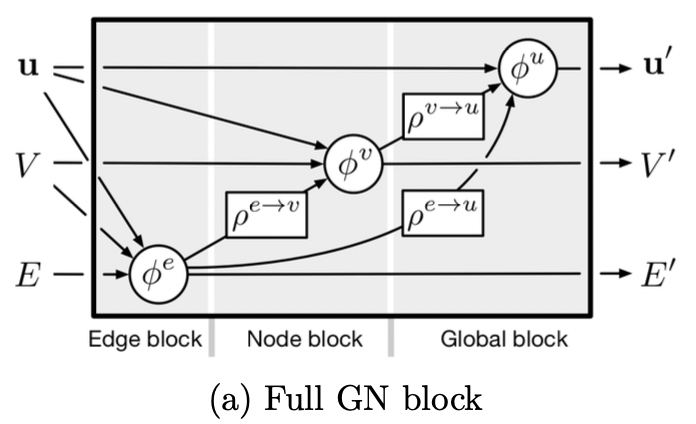

In [ ]:
def GraphNetwork(  # pylint: disable=invalid-name
    update_edge_fn: Mapping[str, jraph.GNUpdateEdgeFn],
    update_node_fn: Mapping[str, GNUpdateNodeFn],
    update_global_fn: Optional[GNUpdateGlobalFn] = None,
    aggregate_edges_for_nodes_fn: jraph.AggregateEdgesToNodesFn = jraph
    .segment_sum,
    aggregate_nodes_for_globals_fn: jraph.AggregateNodesToGlobalsFn = jraph
    .segment_sum,
    aggregate_edges_for_globals_fn: jraph.AggregateEdgesToGlobalsFn = jraph
    .segment_sum,
    ):
  def _apply_graph_net(graph: typed_graph.TypedGraph) -> typed_graph.TypedGraph:
    updated_graph = graph

    # Edge update.
    updated_edges = dict(updated_graph.edges)
    for edge_set_name, edge_fn in update_edge_fn.items():
      edge_set_key = graph.edge_key_by_name(edge_set_name)
      updated_edges[edge_set_key] = _edge_update(
          updated_graph, edge_fn, edge_set_key)
    updated_graph = updated_graph._replace(edges=updated_edges)

    # Node update.
    updated_nodes = dict(updated_graph.nodes)
    for node_set_key, node_fn in update_node_fn.items():
      updated_nodes[node_set_key] = _node_update(
          updated_graph, node_fn, node_set_key, aggregate_edges_for_nodes_fn)
    updated_graph = updated_graph._replace(nodes=updated_nodes)

    # Global update.
    if update_global_fn:
      updated_context = _global_update(
          updated_graph, update_global_fn,
          aggregate_edges_for_globals_fn,
          aggregate_nodes_for_globals_fn)
      updated_graph = updated_graph._replace(context=updated_context)

    return updated_graph

  return _apply_graph_net

Message-passing neural network or Full GN block? (paper Figure 4, page 16)

function _edge_update corresponds to step 1. Let's take a close look at it.

In [ ]:
def _edge_update(graph, edge_fn, edge_set_key):
  sender_nodes = graph.nodes[edge_set_key.node_sets[0]]
  receiver_nodes = graph.nodes[edge_set_key.node_sets[1]]
  edge_set = graph.edges[edge_set_key]
  senders = edge_set.indices.senders
  receivers = edge_set.indices.receivers

  sent_attributes = tree.tree_map(
      lambda n: n[senders], sender_nodes.features)
  received_attributes = tree.tree_map(
      lambda n: n[receivers], receiver_nodes.features)

  n_edge = edge_set.n_edge
  sum_n_edge = senders.shape[0]
  global_features = tree.tree_map(
      lambda g: jnp.repeat(g, n_edge, axis=0, total_repeat_length=sum_n_edge),
      graph.context.features)
  new_features = edge_fn(
      edge_set.features, sent_attributes, received_attributes,
      global_features)
  return edge_set._replace(features=new_features)

function _node_update corresponds to step 2, 3.

In [ ]:
def _node_update(graph, node_fn, node_set_key, aggregation_fn):
  node_set = graph.nodes[node_set_key]
  sum_n_node = tree.tree_leaves(node_set.features)[0].shape[0]

  sent_features = {}
  for edge_set_key, edge_set in graph.edges.items():
    sender_node_set_key = edge_set_key.node_sets[0]
    if sender_node_set_key == node_set_key:
      assert isinstance(edge_set.indices, typed_graph.EdgesIndices)
      senders = edge_set.indices.senders
      sent_features[edge_set_key.name] = tree.tree_map(
          lambda e: aggregation_fn(e, senders, sum_n_node), edge_set.features)

  received_features = {}
  for edge_set_key, edge_set in graph.edges.items():
    receiver_node_set_key = edge_set_key.node_sets[1]
    if receiver_node_set_key == node_set_key:
      assert isinstance(edge_set.indices, typed_graph.EdgesIndices)
      receivers = edge_set.indices.receivers
      received_features[edge_set_key.name] = tree.tree_map(
          lambda e: aggregation_fn(e, receivers, sum_n_node), edge_set.features)

  n_node = node_set.n_node
  global_features = tree.tree_map(
      lambda g: jnp.repeat(g, n_node, axis=0, total_repeat_length=sum_n_node),
      graph.context.features)
  new_features = node_fn(
      node_set.features, sent_features, received_features, global_features)
  return node_set._replace(features=new_features)

function _global_update corresponds to step 4, 5, 6.

In [ ]:
def _global_update(graph, global_fn, edge_aggregation_fn, node_aggregation_fn):
  n_graph = graph.context.n_graph.shape[0]
  graph_idx = jnp.arange(n_graph)

  edge_features = {}
  for edge_set_key, edge_set in graph.edges.items():
    assert isinstance(edge_set.indices, typed_graph.EdgesIndices)
    sum_n_edge = edge_set.indices.senders.shape[0]
    edge_gr_idx = jnp.repeat(
        graph_idx, edge_set.n_edge, axis=0, total_repeat_length=sum_n_edge)
    edge_features[edge_set_key.name] = tree.tree_map(
        lambda e: edge_aggregation_fn(e, edge_gr_idx, n_graph),
        edge_set.features)

  node_features = {}
  for node_set_key, node_set in graph.nodes.items():
    sum_n_node = tree.tree_leaves(node_set.features)[0].shape[0]
    node_gr_idx = jnp.repeat(
        graph_idx, node_set.n_node, axis=0, total_repeat_length=sum_n_node)
    node_features[node_set_key] = tree.tree_map(
        lambda n: node_aggregation_fn(n, node_gr_idx, n_graph),
        node_set.features)

  new_features = global_fn(node_features, edge_features, graph.context.features)
  return graph.context._replace(features=new_features)

The following function defines a GN with interaction networks style. Interaction Networks uses a full GN but for the absence of the global to update the edge properties. It computes interactions on the edges based on the
previous edges features, and on the features of the nodes sending into those
edges. It then updates the nodes based on the incoming updated edges. <br>
This implementation extends the behavior to `TypedGraphs` adding an option
to include edge features for which a node is a sender in the arguments to
the node update function.

In [ ]:
def InteractionNetwork(
    update_edge_fn: Mapping[str, jraph.InteractionUpdateEdgeFn],
    update_node_fn: Mapping[str, Union[InteractionUpdateNodeFn,
                                       InteractionUpdateNodeFnNoSentEdges]],
    aggregate_edges_for_nodes_fn: jraph.AggregateEdgesToNodesFn = jraph
    .segment_sum,
    include_sent_messages_in_node_update: bool = False):

  wrapped_update_edge_fn = tree.tree_map(
      lambda fn: lambda e, s, r, g: fn(e, s, r), update_edge_fn)
  if include_sent_messages_in_node_update:
    wrapped_update_node_fn = tree.tree_map(
        lambda fn: lambda n, s, r, g: fn(n, s, r), update_node_fn)
  else:
    wrapped_update_node_fn = tree.tree_map(
        lambda fn: lambda n, s, r, g: fn(n, r), update_node_fn)

  return GraphNetwork(
      update_edge_fn=wrapped_update_edge_fn,
      update_node_fn=wrapped_update_node_fn,
      aggregate_edges_for_nodes_fn=aggregate_edges_for_nodes_fn)

 It works with TypedGraphs with typed nodes and edges. It runs message passing on all of the node sets and all of the edge sets in the graph. For each message passing step a `typed_graph_net.InteractionNetwork` is used to update the full TypedGraph by using different MLPs for each of the node sets and each of the edge sets.

In [ ]:
class DeepTypedGraphNet(hk.Module):

In [ ]:
def __call__(self, input_graph: typed_graph.TypedGraph) -> typed_graph.TypedGraph:
    """Forward pass of the learnable dynamics model."""
    self._networks_builder(input_graph)

    # Embed input features (if applicable).
    latent_graph_0 = self._embed(input_graph)

    # Do `m` message passing steps in the latent graphs.
    latent_graph_m = self._process(latent_graph_0)

    # Compute outputs from the last latent graph (if applicable).
    return self._output(latent_graph_m)

Composable multi-block architectures (paper page 19)

A key design principle of graph networks is constructing complex architectures by composing GN blocks. We defined a GN block as always taking a graph comprised of edge, node, and global elements as input, and returning a graph with the same constituent elements as output. This graph-to-graph input/output interface ensures that the output of one GN block can be passed as input to another, even if their internal configurations are different. <br>
Arbitrary numbers of GN blocks can be composed, as show in Figure 6a. The blocks can be unshared, or shared. The white box around the GNcore in Figure 6a represents M repeated internal processing sub-steps (self._num_message_passing_steps in following function)



self._embedder_network <br>
GraphMapFeatures <br>

function to embed edges: MLP + norm layer <br>
function to embed nodes: MLP + norm layer <br>


self._processor_networks <br>
InteractionNetwork <br>

function to embed edges: MLP + norm layer <br>
function to embed nodes: MLP + norm layer <br>
by default, use jax function segment_sum to aggregate edges for nodes

self._output_network <br>
GraphMapFeatures <br>

function to embed edges: MLP layer <br>
function to embed nodes: MLP layer <br>

In [ ]:
def _networks_builder(self, graph_template):
    if self._initialized:
      return
    self._initialized = True

    def build_mlp(name, output_size):
      mlp = hk.nets.MLP(
          output_sizes=[self._mlp_hidden_size] * self._mlp_num_hidden_layers + [
              output_size], name=name + "_mlp", activation=self._activation)
      return jraph.concatenated_args(mlp)

    def build_mlp_with_maybe_layer_norm(name, output_size):
      network = build_mlp(name, output_size)
      if self._use_layer_norm:
        layer_norm = hk.LayerNorm(
            axis=-1, create_scale=True, create_offset=True,
            name=name + "_layer_norm")
        network = hk.Sequential([network, layer_norm])
      return jraph.concatenated_args(network)

    # The embedder graph network independently embeds edge and node features.
    if self._embed_edges:
      embed_edge_fn = _build_update_fns_for_edge_types(
          build_mlp_with_maybe_layer_norm,
          graph_template,
          "encoder_edges_",
          output_sizes=self._edge_latent_size)
    else:
      embed_edge_fn = None
    if self._embed_nodes:
      embed_node_fn = _build_update_fns_for_node_types(
          build_mlp_with_maybe_layer_norm,
          graph_template,
          "encoder_nodes_",
          output_sizes=self._node_latent_size)
    else:
      embed_node_fn = None
    embedder_kwargs = dict(
        embed_edge_fn=embed_edge_fn,
        embed_node_fn=embed_node_fn,
    )
    self._embedder_network = typed_graph_net.GraphMapFeatures(
        **embedder_kwargs)

    if self._f32_aggregation:
      def aggregate_fn(data, *args, **kwargs):
        dtype = data.dtype
        data = data.astype(jnp.float32)
        output = self._aggregate_edges_for_nodes_fn(data, *args, **kwargs)
        if self._aggregate_normalization:
          output = output / self._aggregate_normalization
        output = output.astype(dtype)
        return output

    else:
      def aggregate_fn(data, *args, **kwargs):
        output = self._aggregate_edges_for_nodes_fn(data, *args, **kwargs)
        if self._aggregate_normalization:
          output = output / self._aggregate_normalization
        return output

    # Create `num_message_passing_steps` graph networks with unshared parameters
    # that update the node and edge latent features.
    # Note that we can use `modules.InteractionNetwork` because
    # it also outputs the messages as updated edge latent features.
    self._processor_networks = []
    for step_i in range(self._num_message_passing_steps):
      self._processor_networks.append(
          typed_graph_net.InteractionNetwork(
              update_edge_fn=_build_update_fns_for_edge_types(
                  build_mlp_with_maybe_layer_norm,
                  graph_template,
                  f"processor_edges_{step_i}_",
                  output_sizes=self._edge_latent_size),
              update_node_fn=_build_update_fns_for_node_types(
                  build_mlp_with_maybe_layer_norm,
                  graph_template,
                  f"processor_nodes_{step_i}_",
                  output_sizes=self._node_latent_size),
              aggregate_edges_for_nodes_fn=aggregate_fn,
              include_sent_messages_in_node_update=(
                  self._include_sent_messages_in_node_update),
              ))

    # The output MLPs converts edge/node latent features into the output sizes.
    output_kwargs = dict(
        embed_edge_fn=_build_update_fns_for_edge_types(
            build_mlp, graph_template, "decoder_edges_", self._edge_output_size)
        if self._edge_output_size else None,
        embed_node_fn=_build_update_fns_for_node_types(
            build_mlp, graph_template, "decoder_nodes_", self._node_output_size)
        if self._node_output_size else None,)
    self._output_network = typed_graph_net.GraphMapFeatures(
        **output_kwargs)

In [ ]:
class GraphCast(predictor_base.Predictor):

The model works on graphs that take into account:
  * Mesh nodes: nodes for the vertices of the mesh.
  * Grid nodes: nodes for the points of the grid.
  * Nodes: When referring to just "nodes", this means the joint set of both mesh nodes, concatenated with grid nodes.

The model works with 3 graphs:
  * Grid2Mesh graph: Graph that contains all nodes. This graph is strictly bipartite with edges going from grid nodes to mesh nodes using a fixed radius query. The grid2mesh_gnn will operate in this graph. The output of this stage will be a latent representation for the mesh nodes, and a latent representation for the grid nodes.
  * Mesh graph: Graph that contains mesh nodes only. The mesh_gnn will operate in this graph. It will update the latent state of the mesh nodes only.
  * Mesh2Grid graph: Graph that contains all nodes. This graph is strictly bipartite with edges going from mesh nodes to grid nodes such that each grid nodes is connected to 3 nodes of the mesh triangular face that contains the grid points. The mesh2grid_gnn will operate in this graph. It will process the updated latent state of the mesh nodes, and the latent state of the grid nodes, to produce the final output for the grid nodes.

  The model is built on top of `TypedGraph`s so the different types of nodes and
  edges can be stored and treated separately.

In [ ]:
def __init__(self, model_config: ModelConfig, task_config: TaskConfig):
    """Initializes the predictor."""
    self._spatial_features_kwargs = dict(
        add_node_positions=False,
        add_node_latitude=True,
        add_node_longitude=True,
        add_relative_positions=True,
        relative_longitude_local_coordinates=True,
        relative_latitude_local_coordinates=True,
    )

    # Specification of the multimesh.
    self._meshes = (
        icosahedral_mesh.get_hierarchy_of_triangular_meshes_for_sphere(
            splits=model_config.mesh_size))

    # Encoder, which moves data from the grid to the mesh with a single message
    # passing step.
    self._grid2mesh_gnn = deep_typed_graph_net.DeepTypedGraphNet(
        embed_nodes=True,  # Embed raw features of the grid and mesh nodes.
        embed_edges=True,  # Embed raw features of the grid2mesh edges.
        edge_latent_size=dict(grid2mesh=model_config.latent_size),
        node_latent_size=dict(
            mesh_nodes=model_config.latent_size,
            grid_nodes=model_config.latent_size),
        mlp_hidden_size=model_config.latent_size,
        mlp_num_hidden_layers=model_config.hidden_layers,
        num_message_passing_steps=1,
        use_layer_norm=True,
        include_sent_messages_in_node_update=False,
        activation="swish",
        f32_aggregation=True,
        aggregate_normalization=None,
        name="grid2mesh_gnn",
    )

    # Processor, which performs message passing on the multi-mesh.
    self._mesh_gnn = deep_typed_graph_net.DeepTypedGraphNet(
        embed_nodes=False,  # Node features already embdded by previous layers.
        embed_edges=True,  # Embed raw features of the multi-mesh edges.
        node_latent_size=dict(mesh_nodes=model_config.latent_size),
        edge_latent_size=dict(mesh=model_config.latent_size),
        mlp_hidden_size=model_config.latent_size,
        mlp_num_hidden_layers=model_config.hidden_layers,
        num_message_passing_steps=model_config.gnn_msg_steps,
        use_layer_norm=True,
        include_sent_messages_in_node_update=False,
        activation="swish",
        f32_aggregation=False,
        name="mesh_gnn",
    )

    num_surface_vars = len(set(task_config.target_variables) - set(ALL_ATMOSPHERIC_VARS))
    num_atmospheric_vars = len(set(task_config.target_variables) & set(ALL_ATMOSPHERIC_VARS))
    num_outputs = (num_surface_vars + len(task_config.pressure_levels) * num_atmospheric_vars)

    # Decoder, which moves data from the mesh back into the grid with a single
    # message passing step.
    self._mesh2grid_gnn = deep_typed_graph_net.DeepTypedGraphNet(
        # Require a specific node dimensionaly for the grid node outputs.
        node_output_size=dict(grid_nodes=num_outputs),
        embed_nodes=False,  # Node features already embdded by previous layers.
        embed_edges=True,  # Embed raw features of the mesh2grid edges.
        edge_latent_size=dict(mesh2grid=model_config.latent_size),
        node_latent_size=dict(
            mesh_nodes=model_config.latent_size,
            grid_nodes=model_config.latent_size),
        mlp_hidden_size=model_config.latent_size,
        mlp_num_hidden_layers=model_config.hidden_layers,
        num_message_passing_steps=1,
        use_layer_norm=True,
        include_sent_messages_in_node_update=False,
        activation="swish",
        f32_aggregation=False,
        name="mesh2grid_gnn",
    )

    # Obtain the query radius in absolute units for the unit-sphere for the
    # grid2mesh model, by rescaling the `radius_query_fraction_edge_length`.
    self._query_radius = (_get_max_edge_distance(self._finest_mesh)
                          * model_config.radius_query_fraction_edge_length)
    self._mesh2grid_edge_normalization_factor = (
        model_config.mesh2grid_edge_normalization_factor
    )

    # Other initialization is delayed until the first call (`_maybe_init`)
    # when we get some sample data so we know the lat/lon values.
    self._initialized = False

    # A "_init_mesh_properties":
    # This one could be initialized at init but we delay it for consistency too.
    self._num_mesh_nodes = None  # num_mesh_nodes
    self._mesh_nodes_lat = None  # [num_mesh_nodes]
    self._mesh_nodes_lon = None  # [num_mesh_nodes]

    # A "_init_grid_properties":
    self._grid_lat = None  # [num_lat_points]
    self._grid_lon = None  # [num_lon_points]
    self._num_grid_nodes = None  # num_lat_points * num_lon_points
    self._grid_nodes_lat = None  # [num_grid_nodes]
    self._grid_nodes_lon = None  # [num_grid_nodes]

    # A "_init_{grid2mesh,processor,mesh2grid}_graph"
    self._grid2mesh_graph_structure = None
    self._mesh_graph_structure = None
    self._mesh2grid_graph_structure = None

In [ ]:
def __call__(self,
               inputs: xarray.Dataset,
               targets_template: xarray.Dataset,
               forcings: xarray.Dataset,
               is_training: bool = False,
               ) -> xarray.Dataset:
    self._maybe_init(inputs)

    # Convert all input data into flat vectors for each of the grid nodes.
    grid_node_features = self._inputs_to_grid_node_features(inputs, forcings)

    # Transfer data for the grid to the mesh,
    (latent_mesh_nodes, latent_grid_nodes
     ) = self._run_grid2mesh_gnn(grid_node_features)

    # Run message passing in the multimesh.
    updated_latent_mesh_nodes = self._run_mesh_gnn(latent_mesh_nodes)

    # Transfer data frome the mesh to the grid.
    output_grid_nodes = self._run_mesh2grid_gnn(
        updated_latent_mesh_nodes, latent_grid_nodes)

    # Conver output flat vectors for the grid nodes to the format of the output.
    # [num_grid_nodes, batch, output_size] ->
    # xarray (batch, one time step, lat, lon, level, multiple vars)
    return self._grid_node_outputs_to_prediction(
        output_grid_nodes, targets_template)

in Grid2Mesh graph, there are two types of nodes: grid_nodes and mesh_nodes. there is one type of edges: grid2mesh.

In [ ]:
def _init_grid2mesh_graph(self) -> typed_graph.TypedGraph:
    """Build Grid2Mesh graph."""

    # Create some edges according to distance between mesh and grid nodes.
    assert self._grid_lat is not None and self._grid_lon is not None
    (grid_indices, mesh_indices) = grid_mesh_connectivity.radius_query_indices(
        grid_latitude=self._grid_lat,
        grid_longitude=self._grid_lon,
        mesh=self._finest_mesh,
        radius=self._query_radius)

    # Edges sending info from grid to mesh.
    senders = grid_indices
    receivers = mesh_indices

    # Precompute structural node and edge features according to config options.
    # Structural features are those that depend on the fixed values of the
    # latitude and longitudes of the nodes.
    (senders_node_features, receivers_node_features,
     edge_features) = model_utils.get_bipartite_graph_spatial_features(
         senders_node_lat=self._grid_nodes_lat,
         senders_node_lon=self._grid_nodes_lon,
         receivers_node_lat=self._mesh_nodes_lat,
         receivers_node_lon=self._mesh_nodes_lon,
         senders=senders,
         receivers=receivers,
         edge_normalization_factor=None,
         **self._spatial_features_kwargs,
     )

    n_grid_node = np.array([self._num_grid_nodes])
    n_mesh_node = np.array([self._num_mesh_nodes])
    n_edge = np.array([mesh_indices.shape[0]])
    grid_node_set = typed_graph.NodeSet(
        n_node=n_grid_node, features=senders_node_features)
    mesh_node_set = typed_graph.NodeSet(
        n_node=n_mesh_node, features=receivers_node_features)
    edge_set = typed_graph.EdgeSet(
        n_edge=n_edge,
        indices=typed_graph.EdgesIndices(senders=senders, receivers=receivers),
        features=edge_features)
    nodes = {"grid_nodes": grid_node_set, "mesh_nodes": mesh_node_set}
    edges = {
        typed_graph.EdgeSetKey("grid2mesh", ("grid_nodes", "mesh_nodes")):
            edge_set
    }
    grid2mesh_graph = typed_graph.TypedGraph(
        context=typed_graph.Context(n_graph=np.array([1]), features=()),
        nodes=nodes,
        edges=edges)
    return grid2mesh_graph

in Mesh graph, there is one type of nodes: mesh_nodes. There is one type of edges: mesh.

In [ ]:
  def _init_mesh_graph(self) -> typed_graph.TypedGraph:
    """Build Mesh graph."""
    merged_mesh = icosahedral_mesh.merge_meshes(self._meshes)

    # Work simply on the mesh edges.
    senders, receivers = icosahedral_mesh.faces_to_edges(merged_mesh.faces)

    # Precompute structural node and edge features according to config options.
    # Structural features are those that depend on the fixed values of the
    # latitude and longitudes of the nodes.
    assert self._mesh_nodes_lat is not None and self._mesh_nodes_lon is not None
    node_features, edge_features = model_utils.get_graph_spatial_features(
        node_lat=self._mesh_nodes_lat,
        node_lon=self._mesh_nodes_lon,
        senders=senders,
        receivers=receivers,
        **self._spatial_features_kwargs,
    )

    n_mesh_node = np.array([self._num_mesh_nodes])
    n_edge = np.array([senders.shape[0]])
    assert n_mesh_node == len(node_features)
    mesh_node_set = typed_graph.NodeSet(
        n_node=n_mesh_node, features=node_features)
    edge_set = typed_graph.EdgeSet(
        n_edge=n_edge,
        indices=typed_graph.EdgesIndices(senders=senders, receivers=receivers),
        features=edge_features)
    nodes = {"mesh_nodes": mesh_node_set}
    edges = {
        typed_graph.EdgeSetKey("mesh", ("mesh_nodes", "mesh_nodes")): edge_set
    }
    mesh_graph = typed_graph.TypedGraph(
        context=typed_graph.Context(n_graph=np.array([1]), features=()),
        nodes=nodes,
        edges=edges)

    return mesh_graph

in Mesh2Grid graph, there are two types of nodes: grid_nodes and mesh_nodes. There is one type of edges: mesh2grid.

In [ ]:
def _init_mesh2grid_graph(self) -> typed_graph.TypedGraph:
    """Build Mesh2Grid graph."""

    # Create some edges according to how the grid nodes are contained by
    # mesh triangles.
    (grid_indices,
     mesh_indices) = grid_mesh_connectivity.in_mesh_triangle_indices(
         grid_latitude=self._grid_lat,
         grid_longitude=self._grid_lon,
         mesh=self._finest_mesh)

    # Edges sending info from mesh to grid.
    senders = mesh_indices
    receivers = grid_indices

    # Precompute structural node and edge features according to config options.
    assert self._mesh_nodes_lat is not None and self._mesh_nodes_lon is not None
    (senders_node_features, receivers_node_features,
     edge_features) = model_utils.get_bipartite_graph_spatial_features(
         senders_node_lat=self._mesh_nodes_lat,
         senders_node_lon=self._mesh_nodes_lon,
         receivers_node_lat=self._grid_nodes_lat,
         receivers_node_lon=self._grid_nodes_lon,
         senders=senders,
         receivers=receivers,
         edge_normalization_factor=self._mesh2grid_edge_normalization_factor,
         **self._spatial_features_kwargs,
     )

    n_grid_node = np.array([self._num_grid_nodes])
    n_mesh_node = np.array([self._num_mesh_nodes])
    n_edge = np.array([senders.shape[0]])
    grid_node_set = typed_graph.NodeSet(
        n_node=n_grid_node, features=receivers_node_features)
    mesh_node_set = typed_graph.NodeSet(
        n_node=n_mesh_node, features=senders_node_features)
    edge_set = typed_graph.EdgeSet(
        n_edge=n_edge,
        indices=typed_graph.EdgesIndices(senders=senders, receivers=receivers),
        features=edge_features)
    nodes = {"grid_nodes": grid_node_set, "mesh_nodes": mesh_node_set}
    edges = {
        typed_graph.EdgeSetKey("mesh2grid", ("mesh_nodes", "grid_nodes")):
            edge_set
    }
    mesh2grid_graph = typed_graph.TypedGraph(
        context=typed_graph.Context(n_graph=np.array([1]), features=()),
        nodes=nodes,
        edges=edges)
    return mesh2grid_graph

In [3]:
import dataclasses
import datetime
import functools
import math
import re
from typing import Optional

# import cartopy.crs as ccrs
from google.cloud import storage
# from graphcast import autoregressive
# from graphcast import casting
# from graphcast import checkpoint
# from graphcast import data_utils
# from graphcast import graphcast
# from graphcast import normalization
# from graphcast import rollout
# from graphcast import xarray_jax
# from graphcast import xarray_tree
# import autoregressive
# import casting
# import checkpoint
import data_utils
import graphcast
# import normalization
# import rollout
import xarray_jax
import xarray_tree
from IPython.display import HTML
import ipywidgets as widgets
import haiku as hk
import jax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import xarray
from pprint import pprint


def parse_file_parts(file_name):
  return dict(part.split("-", 1) for part in file_name.split("_"))

gcs_client = storage.Client.create_anonymous_client()
gcs_bucket = gcs_client.get_bucket("dm_graphcast")

params = None  # Filled in below
state = {}
model_config = graphcast.ModelConfig(
    resolution=0,
    mesh_size=4,
    latent_size=32,
    gnn_msg_steps=1,
    hidden_layers=1,
    radius_query_fraction_edge_length=0.6)
task_config = graphcast.TaskConfig(
    input_variables=graphcast.TASK.input_variables,
    target_variables=graphcast.TASK.target_variables,
    forcing_variables=graphcast.TASK.forcing_variables,
    pressure_levels=graphcast.PRESSURE_LEVELS[13],
    input_duration=graphcast.TASK.input_duration,
)

with gcs_bucket.blob("stats/diffs_stddev_by_level.nc").open("rb") as f:
  diffs_stddev_by_level = xarray.load_dataset(f).compute()
with gcs_bucket.blob("stats/mean_by_level.nc").open("rb") as f:
  mean_by_level = xarray.load_dataset(f).compute()
with gcs_bucket.blob("stats/stddev_by_level.nc").open("rb") as f:
  stddev_by_level = xarray.load_dataset(f).compute()

with gcs_bucket.blob(f"dataset/source-era5_date-2022-01-01_res-0.25_levels-13_steps-01.nc").open("rb") as f:
  example_batch = xarray.load_dataset(f).compute()

# pprint([blob for blob in gcs_bucket.list_blobs(prefix="dataset/")])
# print(example_batch)

train_inputs, train_targets, train_forcings = data_utils.extract_inputs_targets_forcings(
    example_batch, target_lead_times=slice("6h", f"6h"),
    **dataclasses.asdict(task_config))

In [6]:
train_inputs.isel(batch=0)

<xarray.Dataset>
Dimensions:                       (time: 2, lat: 721, lon: 1440, level: 13)
Coordinates:
  * lon                           (lon) float32 0.0 0.25 0.5 ... 359.5 359.8
  * lat                           (lat) float32 -90.0 -89.75 ... 89.75 90.0
  * level                         (level) int32 50 100 150 200 ... 850 925 1000
  * time                          (time) timedelta64[ns] -1 days +18:00:00 00...
Data variables: (12/18)
    2m_temperature                (time, lat, lon) float32 250.7 250.7 ... 248.1
    mean_sea_level_pressure       (time, lat, lon) float32 9.931e+04 ... 1.03...
    10m_v_component_of_wind       (time, lat, lon) float32 -0.4393 ... 0.0812
    10m_u_component_of_wind       (time, lat, lon) float32 1.309 ... -0.2594
    total_precipitation_6hr       (time, lat, lon) float32 0.0004331 ... 5.27...
    temperature                   (time, level, lat, lon) float32 238.4 ... 2...
    ...                            ...
    year_progress_sin             (time) float32 0.006986 0.01129
    year_progress_cos             (time) float32 1.0 0.9999
    day_progress_sin              (time, lon) float32 0.0 0.004363 ... 1.0 1.0
    day_progress_cos              (time, lon) float32 1.0 1.0 ... 0.004363
    geopotential_at_surface       (lat, lon) float32 2.735e+04 ... -0.07617
    land_sea_mask                 (lat, lon) float32 1.0 1.0 1.0 ... 0.0 0.0 0.0

In [7]:
train_forcings.isel(batch=0)

<xarray.Dataset>
Dimensions:                       (time: 1, lat: 721, lon: 1440)
Coordinates:
  * lon                           (lon) float32 0.0 0.25 0.5 ... 359.5 359.8
  * lat                           (lat) float32 -90.0 -89.75 ... 89.75 90.0
  * time                          (time) timedelta64[ns] 06:00:00
Data variables:
    toa_incident_solar_radiation  (time, lat, lon) float32 1.978e+06 ... 0.0
    year_progress_sin             (time) float32 0.01559
    year_progress_cos             (time) float32 0.9999
    day_progress_sin              (time, lon) float32 -8.742e-08 ... 0.004363
    day_progress_cos              (time, lon) float32 -1.0 -1.0 ... -1.0 -1.0

In [6]:
# from graphcast import model_utils
import model_utils

# xarray `Dataset` (batch, time, lat, lon, level, multiple vars) to xarray `DataArray` (batch, lat, lon, channels)
stacked_inputs = model_utils.dataset_to_stacked(train_inputs)
stacked_inputs.isel(batch=0, lat=0, lon=0)
stacked_forcings = model_utils.dataset_to_stacked(train_forcings)
stacked_forcings.isel(batch=0)
stacked_combine = xarray.concat(
    [stacked_inputs, stacked_forcings], dim="channels")
stacked_combine.isel(batch=0)

# # xarray `DataArray` (batch, lat, lon, channels) to single numpy array with shape [lat_lon_node, batch, channels]
grid_xarray_lat_lon_leading = model_utils.lat_lon_to_leading_axes(
    stacked_combine)
final = xarray_jax.unwrap(grid_xarray_lat_lon_leading.data).reshape((-1,) + grid_xarray_lat_lon_leading.data.shape[2:])
final.shape


(1038240, 1, 183)

In [5]:
train_targets.isel(batch=0)

<xarray.Dataset>
Dimensions:                  (time: 1, lat: 721, lon: 1440, level: 13)
Coordinates:
  * lon                      (lon) float32 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * lat                      (lat) float32 -90.0 -89.75 -89.5 ... 89.75 90.0
  * level                    (level) int32 50 100 150 200 ... 700 850 925 1000
  * time                     (time) timedelta64[ns] 06:00:00
Data variables:
    2m_temperature           (time, lat, lon) float32 248.3 248.3 ... 247.4
    mean_sea_level_pressure  (time, lat, lon) float32 9.983e+04 ... 1.033e+05
    10m_v_component_of_wind  (time, lat, lon) float32 -0.04184 ... -0.07012
    10m_u_component_of_wind  (time, lat, lon) float32 0.04857 ... -0.2023
    total_precipitation_6hr  (time, lat, lon) float32 7.443e-05 ... 5.756e-06
    temperature              (time, level, lat, lon) float32 238.1 ... 250.7
    geopotential             (time, level, lat, lon) float32 1.983e+05 ... 2....
    u_component_of_wind      (time, level, lat, lon) float32 0.0006237 ... 7....
    v_component_of_wind      (time, level, lat, lon) float32 0.0003135 ... -7...
    vertical_velocity        (time, level, lat, lon) float32 0.001688 ... 0.0...
    specific_humidity        (time, level, lat, lon) float32 2.898e-06 ... 0....

In [ ]:
def _init_mesh_properties():
    _meshes = (
        icosahedral_mesh.get_hierarchy_of_triangular_meshes_for_sphere(
            splits=model_config.mesh_size))
    _finest_mesh = _meshes[-1]
    _num_mesh_nodes = _finest_mesh.vertices.shape[0]
    mesh_phi, mesh_theta = model_utils.cartesian_to_spherical(
        _finest_mesh.vertices[:, 0],
        _finest_mesh.vertices[:, 1],
        _finest_mesh.vertices[:, 2])
    (
        mesh_nodes_lat,
        mesh_nodes_lon,
    ) = model_utils.spherical_to_lat_lon(phi=mesh_phi, theta=mesh_theta)
    _mesh_nodes_lat = mesh_nodes_lat.astype(np.float32)
    _mesh_nodes_lon = mesh_nodes_lon.astype(np.float32)
    return _mesh_nodes_lat, _mesh_nodes_lon

def _init_grid_properties(self, grid_lat: np.ndarray, grid_lon: np.ndarray):
    _grid_lat = grid_lat.astype(np.float32)
    _grid_lon = grid_lon.astype(np.float32)
    _num_grid_nodes = grid_lat.shape[0] * grid_lon.shape[0]
    grid_nodes_lon, grid_nodes_lat = np.meshgrid(grid_lon, grid_lat)
    _grid_nodes_lon = grid_nodes_lon.reshape([-1]).astype(np.float32)
    _grid_nodes_lat = grid_nodes_lat.reshape([-1]).astype(np.float32)
    return _grid_nodes_lon, _grid_nodes_lon

def _init_grid2mesh_graph():
    (grid_indices, mesh_indices) = grid_mesh_connectivity.radius_query_indices(
        grid_latitude=_grid_lat,
        grid_longitude=_grid_lon,
        mesh=_finest_mesh,
        radius=_query_radius)

    senders = grid_indices
    receivers = mesh_indices

    # Precompute structural node and edge features according to config options.
    # Structural features are those that depend on the fixed values of the
    # latitude and longitudes of the nodes.
    (senders_node_features, receivers_node_features,
     edge_features) = model_utils.get_bipartite_graph_spatial_features(
         senders_node_lat=self._grid_nodes_lat,
         senders_node_lon=self._grid_nodes_lon,
         receivers_node_lat=self._mesh_nodes_lat,
         receivers_node_lon=self._mesh_nodes_lon,
         senders=senders,
         receivers=receivers,
         edge_normalization_factor=None,
         **self._spatial_features_kwargs,
     )

    n_grid_node = np.array([self._num_grid_nodes])
    n_mesh_node = np.array([self._num_mesh_nodes])
    n_edge = np.array([mesh_indices.shape[0]])
    grid_node_set = typed_graph.NodeSet(
        n_node=n_grid_node, features=senders_node_features)
    mesh_node_set = typed_graph.NodeSet(
        n_node=n_mesh_node, features=receivers_node_features)
    edge_set = typed_graph.EdgeSet(
        n_edge=n_edge,
        indices=typed_graph.EdgesIndices(senders=senders, receivers=receivers),
        features=edge_features)
    nodes = {"grid_nodes": grid_node_set, "mesh_nodes": mesh_node_set}
    edges = {
        typed_graph.EdgeSetKey("grid2mesh", ("grid_nodes", "mesh_nodes")):
            edge_set
    }
    grid2mesh_graph = typed_graph.TypedGraph(
        context=typed_graph.Context(n_graph=np.array([1]), features=()),
        nodes=nodes,
        edges=edges)
    return grid2mesh_graph

_mesh_nodes_lat, _mesh_nodes_lon = _init_mesh_properties()
_grid_nodes_lon, _grid_nodes_lon = _init_grid_properties(grid_lat=train_inputs.lat, grid_lon=train_inputs.lon)
_grid2mesh_graph_structure = _init_grid2mesh_graph()
_mesh_graph_structure = _init_mesh_graph()
_mesh2grid_graph_structure = _init_mesh2grid_graph()

In [10]:
@hk.transform_with_state
def run_forward(model_config, task_config, inputs, targets_template, forcings):
    predictor = graphcast.GraphCast(model_config, task_config)
    return predictor(inputs, targets_template, forcings)

# run_forward = hk.transform_with_state(run_forward)

params, state = run_forward.init(rng=jax.random.PRNGKey(0),
    model_config=model_config,
    task_config=task_config,
    inputs=train_inputs,
    targets_template=train_targets * np.nan,
    forcings=train_forcings)

predictions, state = run_forward.apply(
    rng=jax.random.PRNGKey(0),
    params=params,
    state=state,
    model_config=model_config,
    task_config=task_config,
    inputs=train_inputs,
    targets_template=train_targets * np.nan,
    forcings=train_forcings)

# for i in params.keys():
#     pprint(i)

In [14]:
# for i in params.keys():
#   print(i)
predictions[0].geopotential.data

xarray_jax.JaxArrayWrapper(Array([[[[[-0.77160215, -0.7716271 , -0.7716523 , ..., -0.7715278 ,
           -0.7715525 , -0.77157736],
          [-0.7761608 , -0.7761675 , -0.7761955 , ..., -0.7761095 ,
           -0.7761159 , -0.77613294],
          [-0.7813763 , -0.7813916 , -0.7813964 , ..., -0.7813366 ,
           -0.78136176, -0.78137153],
          ...,
          [-1.3384193 , -1.3382986 , -1.3381764 , ..., -1.338788  ,
           -1.338666  , -1.3385439 ],
          [-1.3416574 , -1.3415499 , -1.3414406 , ..., -1.3419878 ,
           -1.3418778 , -1.3417683 ],
          [-1.3458602 , -1.3457606 , -1.345662  , ..., -1.3461605 ,
           -1.3460605 , -1.3459598 ]],

         [[ 1.2508894 ,  1.2509801 ,  1.2510718 , ...,  1.2506162 ,
            1.2507075 ,  1.2507981 ],
          [ 1.2534177 ,  1.2535036 ,  1.2535838 , ...,  1.2531639 ,
            1.2532527 ,  1.2533368 ],
          [ 1.2551252 ,  1.2552032 ,  1.2552817 , ...,  1.2548864 ,
            1.2549647 ,  1.255043  ],
  

In [16]:
@hk.transform_with_state
def loss_fn(model_config, task_config, inputs, targets, forcings):
  predictor = graphcast.GraphCast(model_config, task_config)
  loss, diagnostics = predictor.loss(inputs, targets, forcings)
  return xarray_tree.map_structure(
      lambda x: xarray_jax.unwrap_data(x.mean(), require_jax=True),
      (loss, diagnostics))

def grads_fn(params, state, model_config, task_config, inputs, targets, forcings):
  def _aux(params, state, i, t, f):
    (loss, diagnostics), next_state = loss_fn.apply(
        params, state, jax.random.PRNGKey(0), model_config, task_config,
        i, t, f)
    return loss, (diagnostics, next_state)
  (loss, (diagnostics, next_state)), grads = jax.value_and_grad(
      _aux, has_aux=True)(params, state, inputs, targets, forcings)
  return loss, diagnostics, next_state, grads


In [18]:
loss, diagnostics, next_state, grads = grads_fn(
    params=params,
    state=state,
    model_config=model_config,
    task_config=task_config,
    inputs=train_inputs,
    targets=train_targets,
    forcings=train_forcings)

pprint(loss)
pprint(diagnostics)
pprint(next_state)
pprint(grads)

Array(4.4665206e+09, dtype=float32)
{'10m_u_component_of_wind': Array(30.391376, dtype=float32),
 '10m_v_component_of_wind': Array(22.698605, dtype=float32),
 '2m_temperature': Array(82456.484, dtype=float32),
 'geopotential': Array(3.442748e+09, dtype=float32),
 'mean_sea_level_pressure': Array(1.0236197e+10, dtype=float32),
 'specific_humidity': Array(0.5176066, dtype=float32),
 'temperature': Array(70838.18, dtype=float32),
 'total_precipitation_6hr': Array(1.0461565, dtype=float32),
 'u_component_of_wind': Array(181.4897, dtype=float32),
 'v_component_of_wind': Array(70.59846, dtype=float32),
 'vertical_velocity': Array(0.67289263, dtype=float32)}
{}
{'grid2mesh_gnn/~_networks_builder/encoder_edges_grid2mesh_layer_norm': {'offset': Array([-557.04126 ,  775.3357  , -512.531   , -591.2892  ,  769.60254 ,
       -721.3804  ,  -37.67065 ,  721.57263 , -407.29462 ,  359.32434 ,
       -517.51526 ,   20.292305,   81.41185 ,   75.16058 ,  -68.23538 ,
       -260.60898 , -747.08685 , -104.

autoregressive

xarray deep dive

Jax deep dive

- PRNG key
- scan

haiku deep dive

- hk.nets.MLP
- hk.transform
- hk.transform_with_state
- hk.remat